In [2]:
import os, sys
from glob import glob
import numpy as np
import dask
import xarray as xr
from scipy.signal import welch
import xrft
from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *
#from mitequinox.sigp import *
from mitequinox.plot import *

In [3]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster(cores=1, processes=1, walltime='01:30:00')
w = cluster.scale(1)
from dask.distributed import Client
client = Client(cluster)

In [4]:
client 

Client Scheduler: tcp://10.148.0.219:45101 Dashboard: http://10.148.0.219:8787/status,Cluster Workers: 1 Cores: 1 Memory: 120.00 GB


________________
# Test spectra

### This script is to test the Parseval's theorem (i.e., total variance in the time domain equals total variance in the frequency domain) - the key to make sure that all the spectral diagnostics are done properly.

In [5]:
time_length = 8640 # year-long time series 

ds = xr.Dataset(coords={'time': ('time', np.arange(time_length)*3600.)}) # with hourly interval
# wave-like signals
ds = ds.assign(u_cos = np.cos(2.*np.pi*2/86400.*ds.time).chunk({'time': time_length}) )
# wave-like signals + random noise
ds = ds.assign(u_cos_noise = ds.u_cos + np.random.randn(ds.time.size)/5)
# wave-like signals + linear(positive) trend
ds = ds.assign(u_cos_trend = ds.u_cos + np.arange(time_length)/time_length)
# wave-like signals + random noise + linear(positive) trend
ds = ds.assign(u_cos_noise_trend = ds.u_cos_noise + np.arange(time_length)/time_length)
print(ds)

<xarray.Dataset>
Dimensions:            (time: 8640)
Coordinates:
  * time               (time) float64 0.0 3.6e+03 7.2e+03 ... 3.11e+07 3.11e+07
Data variables:
    u_cos              (time) float64 dask.array<chunksize=(8640,), meta=np.ndarray>
    u_cos_noise        (time) float64 dask.array<chunksize=(8640,), meta=np.ndarray>
    u_cos_trend        (time) float64 dask.array<chunksize=(8640,), meta=np.ndarray>
    u_cos_noise_trend  (time) float64 dask.array<chunksize=(8640,), meta=np.ndarray>


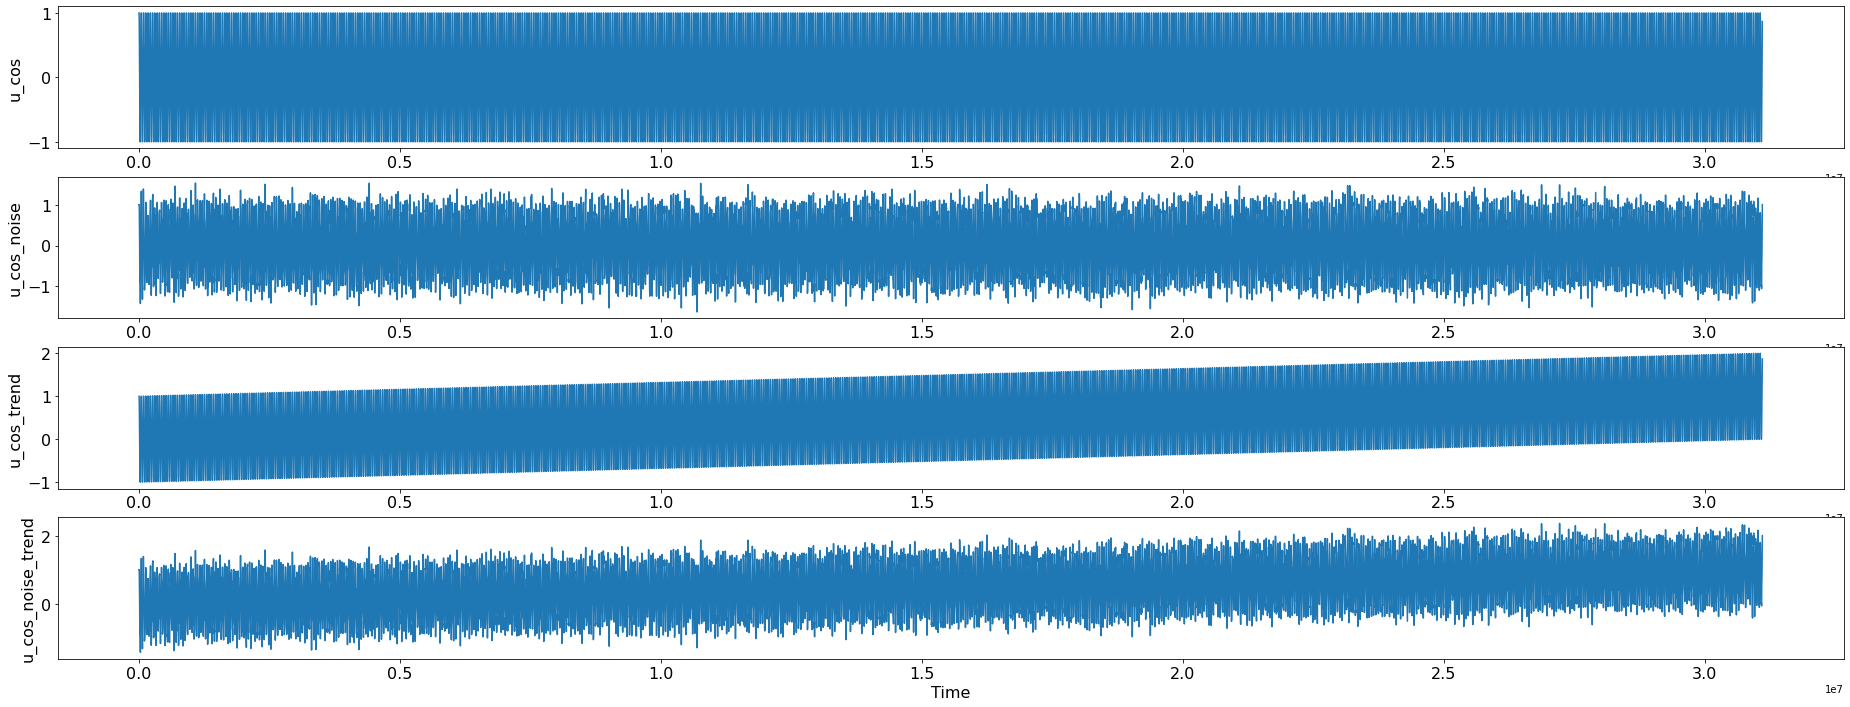

In [6]:
fig, ax = plt.subplots(figsize=(32,12))

ax = plt.subplot(4,1,1)
ds.u_cos.plot()
ax.set_xlabel('',fontsize=16)
ax.set_ylabel('u_cos',fontsize=16)
ax.tick_params(labelsize=16)

ax = plt.subplot(4,1,2)
ds.u_cos_noise.plot()
ax.set_xlabel('',fontsize=16)
ax.set_ylabel('u_cos_noise',fontsize=16)
ax.tick_params(labelsize=16)

ax = plt.subplot(4,1,3)
ds.u_cos_trend.plot()
ax.set_xlabel('',fontsize=16)
ax.set_ylabel('u_cos_trend',fontsize=16)
ax.tick_params(labelsize=16)

ax = plt.subplot(4,1,4)
ds.u_cos_noise_trend.plot()
ax.set_xlabel('Time',fontsize=16)
ax.set_ylabel('u_cos_noise_trend',fontsize=16)
ax.tick_params(labelsize=16)

In [7]:
# variance in the time domain
(ds.u_cos**2).mean(dim='time').compute()

<xarray.DataArray 'u_cos' ()>
array(0.5)

In [8]:
# variance in the time domain
(ds.u_cos_noise**2).mean(dim='time').compute()

<xarray.DataArray 'u_cos_noise' ()>
array(0.54210789)

In [9]:
(ds.u_cos_trend**2).mean(dim='time').compute()

<xarray.DataArray 'u_cos_trend' ()>
array(0.83315972)

In [10]:
(ds.u_cos_noise_trend**2).mean(dim='time').compute()

<xarray.DataArray 'u_cos_noise_trend' ()>
array(0.87427582)

## spectral test 1: no blocks

In [54]:
uv_fft_complex = xrft.dft(ds.u_cos_noise_trend, dim=['time'], shift=False, detrend=False, window=None, chunks_to_segments=False)
E_uv_blocks = (uv_fft_complex*uv_fft_complex.conj()).where(uv_fft_complex!=0., drop=False)/8640*3600
E_uv_blocks = np.real(E_uv_blocks).rename('E_uv_blocks')
E_uv_blocks

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.8/site-packages/xrft/xrft.py:336: FutureWarning: Flags true_phase and true_amplitude will be set to True in future versions of xrft.dft to preserve the theoretical phasing and amplitude of Fourier Transform. Consider using xrft.fft to ensure future compatibility with numpy.fft like behavior and to deactivate this warning.
  warnings.warn(msg, FutureWarning)


<xarray.DataArray 'E_uv_blocks' (freq_time: 8640)>
dask.array<real, shape=(8640,), dtype=float64, chunksize=(8640,), chunktype=numpy.ndarray>
Coordinates:
  * freq_time  (freq_time) float64 0.0 3.215e-08 ... -6.43e-08 -3.215e-08

In [55]:
df = E_uv_blocks.freq_time[1]-E_uv_blocks.freq_time[0]
df

<xarray.DataArray 'freq_time' ()>
array(3.21502058e-08)

In [56]:
(E_uv_blocks*df).sum(dim='freq_time').compute() 

<xarray.DataArray ()>
array(0.87427582)

In [88]:
uv_p = xrft.power_spectrum(ds.u_cos_noise_trend, dim=['time'], window_correction=False, caling='density', shift=False, detrend=False, window=None, chunks_to_segments=False)
(uv_p*df).sum(dim='freq_time').compute() 

<xarray.DataArray ()>
array(0.87427582)

In [89]:
uv_p = xrft.power_spectrum(ds.u_cos_noise_trend, dim=['time'], window_correction=True, caling='density', shift=False, detrend=False, window='hann', chunks_to_segments=False)
(uv_p*df).sum(dim='freq_time').compute() 

<xarray.DataArray ()>
array(0.81333166)

In [86]:
uv_p = xrft.power_spectrum(ds.u_cos_noise_trend, dim=['time'], window_correction=False, caling='density', shift=False, detrend='linear', window='hann', chunks_to_segments=False)
(uv_p*df).sum(dim='freq_time').compute() 

<xarray.DataArray ()>
array(0.20365308)

In [87]:
uv_p = xrft.power_spectrum(ds.u_cos_noise_trend, dim=['time'], window_correction=True, caling='density', shift=False, detrend='linear', window='hann', chunks_to_segments=False)
(uv_p*df).sum(dim='freq_time').compute() 

<xarray.DataArray ()>
array(0.54307488)

In [16]:
#from mitequinox.sigp import *
from scipy import signal

In [98]:
def _get_E(x, ufunc=True, **kwargs):
    ax = -1 if ufunc else 0
    #
    dkwargs = {
        "window": "boxcar",
        "return_onesided": False,
        "detrend": 'linear',
        "scaling": "density",
        "noverlap": 960,
    }
    dkwargs.update(kwargs)
    f, E = signal.welch(x, fs=24.0, axis=ax, **dkwargs)
    #
    if ufunc:
        return E
    else:
        return f, E

def get_E(v, f=None, **kwargs):
    v = v.chunk({"time": len(v.time)})
    if "nperseg" in kwargs:
        Nb = kwargs["nperseg"]
    else:
        Nb = 24*60
        kwargs["nperseg"] = Nb
    if f is None:
        f, E = _get_E(v.values, ufunc=False, **kwargs)
        return f, E
    else:
        E = xr.apply_ufunc(
            _get_E,
            v,
            dask="parallelized",
            output_dtypes=[np.float64],
            input_core_dims=[["time"]],
            output_core_dims=[["freq_time"]],
            dask_gufunc_kwargs={"output_sizes": {"freq_time": Nb}},
            kwargs=kwargs,
        )
        E = E.assign_coords(freq_time=f).sortby("freq_time")
        return E

f, E = get_E(ds['u_cos_noise_trend'])
E = get_E(ds['u_cos_noise_trend'], f=f)
#E = E.to_dataset()

df_8640 = E.freq_time[1]-E.freq_time[0]
#(E.u_cos_trend*df_8640).sum(dim='freq_time').compute() 
(E*df_8640).sum(dim='freq_time').compute() 

<xarray.DataArray ()>
array(0.54253355)

In [25]:
df_8640 = E.freq_time[1]-E.freq_time[0]
print(df_8640)

<xarray.DataArray 'freq_time' ()>
array(0.00277778)


In [19]:
(E.u_cos_noise*df_8640).sum(dim='freq_time').compute() 

<xarray.DataArray ()>
array(0.54307488)

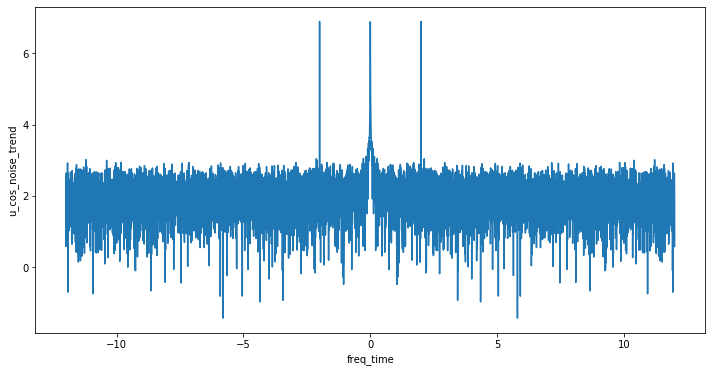

In [14]:
fig, ax = plt.subplots(figsize=(12,6))
ax = plt.subplot(111)
np.log10(E.u_cos_noise_trend*86400).plot()

In [28]:
(E.u_cos_noise_trend*df_8640).sum(dim='freq_time').compute() 

<xarray.DataArray ()>
array(0.87427582)

## spectral test 2: 2-month blocks

In [21]:
def _get_E(x, ufunc=True, **kwargs):
    ax = -1 if ufunc else 0
    #
    dkwargs = {'window': 'boxcar', 'return_onesided': False, 
               'detrend': 'linear', 'scaling': 'density'}
    dkwargs.update(kwargs)
    f, E = signal.welch(x, fs=24., axis=ax, **dkwargs)
    #
    if ufunc:
        return E
    else:
        return f, E

def get_E(v, f=None, **kwargs):
    v = v.chunk({'time': len(v.time)})
    if 'nperseg' in kwargs:
        Nb = kwargs['nperseg']
    else:
        Nb = 1440
        kwargs['nperseg']= Nb
    if f is None:
        f, E = _get_E(v.values, ufunc=False, **kwargs)
        return f, E
    else:
        E = xr.apply_ufunc(_get_E, v,
                    dask='parallelized', output_dtypes=[np.float64],
                    input_core_dims=[['time']],
                    output_core_dims=[['freq_time']],
                    output_sizes={'freq_time': Nb}, kwargs=kwargs)
        return E.assign_coords(freq_time=f).sortby('freq_time')
    
f1, E1 = get_E(ds['u_cos_noise_trend'])
E1 = get_E(ds['u_cos_noise_trend'], f=f1)
E1 = E1.to_dataset()
E1

<ipython-input-21-fdaa5e884671>:25: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  E = xr.apply_ufunc(_get_E, v,


<xarray.Dataset>
Dimensions:            (freq_time: 1440)
Coordinates:
  * freq_time          (freq_time) float64 -12.0 -11.98 -11.97 ... 11.97 11.98
Data variables:
    u_cos_noise_trend  (freq_time) float64 dask.array<chunksize=(1440,), meta=np.ndarray>

In [22]:
df_1440 = E1.freq_time[1]-E1.freq_time[0]
print(df_1440)

<xarray.DataArray 'freq_time' ()>
array(0.01666667)


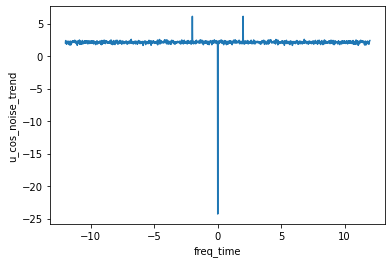

In [23]:
np.log10(E1.u_cos_noise_trend*86400).plot()

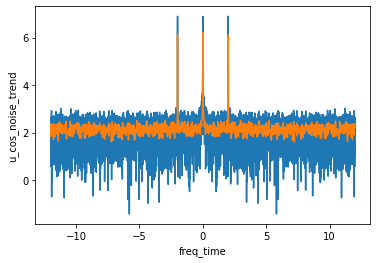

In [19]:
np.log10(E.u_cos_noise_trend*86400).plot()
np.log10(E1.u_cos_noise_trend*86400).plot()

In [24]:
(E1.u_cos_noise_trend*df_1440).sum(dim='freq_time').compute() 

<xarray.DataArray ()>
array(0.54457853)

In [20]:
(E.u_cos_noise_trend*df_8640).sum(dim='freq_time').compute() 

NameError: name 'E' is not defined

In [26]:
df_1440

<xarray.DataArray 'freq_time' ()>
array(0.01666667)

In [27]:
df_8640

<xarray.DataArray 'freq_time' ()>
array(0.00277778)

In [22]:
df_1440/df_8640

<xarray.DataArray 'freq_time' ()>
array(6.)

## spectral test 3: with windowing and 2-month blocks

In [48]:
def _get_E(x, ufunc=True, **kwargs):
    ax = -1 if ufunc else 0
    #
    dkwargs = {'return_onesided': False, 
               'detrend': 'linear', 'scaling': 'density'}
    dkwargs.update(kwargs)
    f, E = signal.welch(x, fs=24., axis=ax, **dkwargs)
    #
    if ufunc:
        return E
    else:
        return f, E

def get_E(v, f=None, **kwargs):
    v = v.chunk({'time': len(v.time)})
    if 'nperseg' in kwargs:
        Nb = kwargs['nperseg']
    else:
        Nb = 60*24
        kwargs['nperseg']= Nb
    if f is None:
        f, E = _get_E(v.values, ufunc=False, **kwargs)
        return f, E
    else:
        E = xr.apply_ufunc(_get_E, 
                           v,
                           dask='parallelized', 
                           output_dtypes=[np.float64],
                           input_core_dims=[['time']],
                           output_core_dims=[['freq_time']],
                           dask_gufunc_kwargs={'output_sizes': {'freq_time': Nb}},
                           kwargs=kwargs,
                          )
        E = E.assign_coords(freq_time=f).sortby('freq_time')
        return E
    
f2, E2 = get_E(ds['u_cos_noise_trend'])
E2 = get_E(ds['u_cos_noise_trend'], f=f2)
E2 = E2.to_dataset()
E2

<xarray.Dataset>
Dimensions:            (freq_time: 1440)
Coordinates:
  * freq_time          (freq_time) float64 -12.0 -11.98 -11.97 ... 11.97 11.98
Data variables:
    u_cos_noise_trend  (freq_time) float64 dask.array<chunksize=(1440,), meta=np.ndarray>

In [59]:
def _get_EE(x, ufunc=True, **kwargs):
    ax = -1 if ufunc else 0
    #
    dkwargs = {'window': 'bohman', 'return_onesided': False, 
               'detrend': 'linear', 'scaling': 'density'}
    dkwargs.update(kwargs)
    f, E = signal.welch(x, fs=24., axis=ax, **dkwargs)
    #
    if ufunc:
        return E
    else:
        return f, E

def get_EE(v, f=None, **kwargs):
    v = v.chunk({'time': len(v.time)})
    if 'nperseg' in kwargs:
        Nb = kwargs['nperseg']
    else:
        Nb = 8640
        kwargs['nperseg']= Nb
    if f is None:
        f, E = _get_EE(v.values, ufunc=False, **kwargs)
        return f, E
    else:
        E = xr.apply_ufunc(_get_EE, v,
                    dask='parallelized', output_dtypes=[np.float64],
                    input_core_dims=[['time']],
                    output_core_dims=[['freq_time']],
                    output_sizes={'freq_time': Nb}, kwargs=kwargs)
        return E.assign_coords(freq_time=f).sortby('freq_time')
    
f2, E2 = get_EE(ds['u_cos_noise_trend'])
E2 = get_E(ds['u_cos_noise_trend'], f=f2)
E2 = E2.to_dataset()
E2

<ipython-input-51-722763ea3f46>:25: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  E = xr.apply_ufunc(_get_E, v,


ValueError: conflicting sizes for dimension 'freq_time': length 1440 on <this-array> and length 8640 on 'freq_time'

In [57]:
df_1440_window = E2.freq_time[1]-E2.freq_time[0]
print(df_1440_window)

<xarray.DataArray 'freq_time' ()>
array(0.01666667)


In [58]:
(E2.u_cos_noise_trend*df_1440_window).sum(dim='freq_time').compute() 

<xarray.DataArray ()>
array(0.54475809)

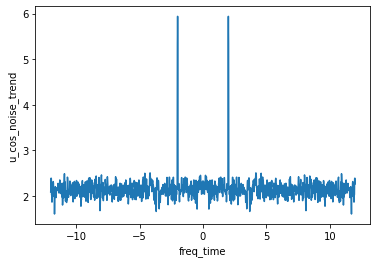

In [14]:
np.log10(E2.u_cos_noise_trend*86400).plot()

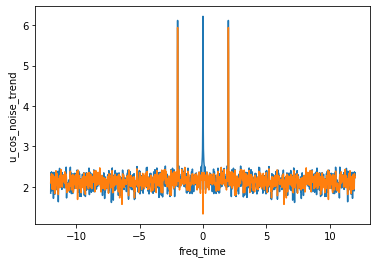

In [60]:
#np.log10(E.u_cos_noise_trend*86400).plot()
np.log10(E1.u_cos_noise_trend*86400).plot()
np.log10(E2.u_cos_noise_trend*86400).plot()

In [15]:
(E2.u_cos_noise_trend*df_1440_window).sum(dim='freq_time').compute() 

<xarray.DataArray ()>
array(0.54465962)

## So Parseval's theorem holds as can be seen that E*df always equals to total variance in the time domain, no matter what block size has been chosen.

## Applying a hanning window seems not reduce the variance in the frequency domain... window effects auto-corrected?

In [65]:
time_length = 8640 # year-long time series 
time = np.arange(time_length)*3600.
u_cos = np.cos(2.*np.pi*2/86400.*time)

In [67]:
u_cos_noise = u_cos + np.random.randn(time.size)/5

In [68]:
u_cos_noise_trend = u_cos_noise + np.arange(time_length)/time_length

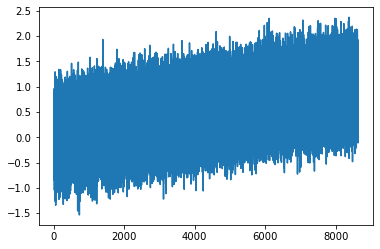

In [70]:
plt.plot(u_cos_noise_trend)

In [77]:
dkwargs = {'window': 'hann', 'return_onesided': False, 'detrend': False, 'scaling': 'density'}
f, E = signal.welch(u_cos_noise_trend, fs=24., **dkwargs)

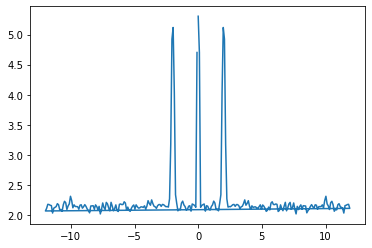

In [78]:
plt.plot(f,np.log10(E*86400))

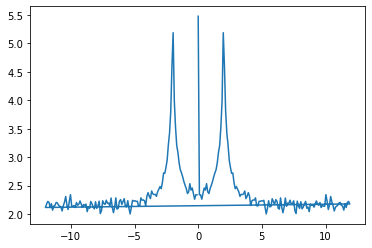

In [76]:
plt.plot(f,np.log10(E*86400))

In [75]:
f

array([  0.     ,   0.09375,   0.1875 ,   0.28125,   0.375  ,   0.46875,
         0.5625 ,   0.65625,   0.75   ,   0.84375,   0.9375 ,   1.03125,
         1.125  ,   1.21875,   1.3125 ,   1.40625,   1.5    ,   1.59375,
         1.6875 ,   1.78125,   1.875  ,   1.96875,   2.0625 ,   2.15625,
         2.25   ,   2.34375,   2.4375 ,   2.53125,   2.625  ,   2.71875,
         2.8125 ,   2.90625,   3.     ,   3.09375,   3.1875 ,   3.28125,
         3.375  ,   3.46875,   3.5625 ,   3.65625,   3.75   ,   3.84375,
         3.9375 ,   4.03125,   4.125  ,   4.21875,   4.3125 ,   4.40625,
         4.5    ,   4.59375,   4.6875 ,   4.78125,   4.875  ,   4.96875,
         5.0625 ,   5.15625,   5.25   ,   5.34375,   5.4375 ,   5.53125,
         5.625  ,   5.71875,   5.8125 ,   5.90625,   6.     ,   6.09375,
         6.1875 ,   6.28125,   6.375  ,   6.46875,   6.5625 ,   6.65625,
         6.75   ,   6.84375,   6.9375 ,   7.03125,   7.125  ,   7.21875,
         7.3125 ,   7.40625,   7.5    ,   7.59375, 

In [99]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
